In [1]:
from wandbhelper.util import init_wandb, log_all_plots, log_plot_as_image

wandb_run_id = init_wandb(run_name="features_engineering")
print(f"Run ID {wandb_run_id}")

wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /home/valeriya/.netrc.
wandb: Currently logged in as: vslovik (homeserve) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Run ID 6g5h86aq


In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from etl.util import prepare_dataset_without_leakage
from ml_features.features import prepare_features
from ml_features.customer_features import create_customer_features
from ml_features.sequence_features  import create_sequence_features
from ml_features.brand_features import create_brand_features
from ml_features.model_features import create_model_features
from ml_features.market_features import create_market_features
from ml_features.equipment_features import create_equipment_features
from ml_features.solution_complexity_features import create_solution_complexity_features
from ml_features.timeline_features import create_timeline_features, create_advanced_timeline_features, create_timeline_interaction_features
from ml_features.role_features import create_commercial_role_features
from ml_features.process_features import create_process_features
from ml_features.correction_features import create_correction_features
from ml_training.train_rf import train_rf
from ml_evaluation.dashboard import model_evaluation_report
from dl_evaluation.evaluation import analyze_input_feature_importance

import warnings
warnings.filterwarnings('ignore')

# Load original clean quote data
df_quotes = pd.read_csv('cleaned_quote_data.csv')
df_quotes['dt_creation_devis'] = pd.to_datetime(df_quotes['dt_creation_devis'])

print(f"\n📊 Original quote data: {len(df_quotes):,} quotes from {df_quotes['numero_compte'].nunique():,} customers")

print("\n" + "="*80)
print("STRATEGY: CREATE FEATURES")
print("="*80)

# Create feature list
feature_funcs = [create_customer_features, create_sequence_features, create_brand_features, 
                 create_model_features, create_market_features,
                 create_equipment_features, create_solution_complexity_features,
                 create_timeline_features, create_advanced_timeline_features,
                 create_commercial_role_features, create_process_features, create_correction_features]


new_df = feature_funcs[0](df_quotes)
customer_df = new_df
for func in feature_funcs[1:]:
    new_df_ = func(df_quotes)

    new_df = pd.merge(new_df, new_df_, on='numero_compte', how='left', suffixes=('_dup', ''))
    new_df = new_df.drop(columns=[x for x in new_df.columns if '_dup' in x], errors='ignore')
    print(len(new_df))
    if func == create_sequence_features: sequence_df = new_df


# Now it's clear which column is which
y_new = new_df['converted']  # From sequence features
y_sequence = sequence_df['converted']  # From sequence features
y_customer = customer_df['converted']  # From customer features

# For modeling, use the sequence version
X_customer = customer_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_customer_clean, y_customer_clean = prepare_features(X_customer, y_customer, "Customer Features")

columns_to_drop =  [x for x in sequence_df.columns if '_seq' in x]
columns_to_drop.extend(['numero_compte', 'converted'])
X_sequence = sequence_df.drop(columns=columns_to_drop, errors='ignore')
X_sequence_clean, y_sequence_clean = prepare_features(X_sequence, y_sequence, "Sequence Features")

new_df = create_timeline_interaction_features(new_df)
X_new = new_df.drop(columns=['numero_compte', 'converted'], errors='ignore')
X_new_clean, y_new_clean = prepare_features(X_new, y_new, "New Features")

from dl_training.train import train_advanced_dl_model
from dl_features.features import create_dl_specific_features, create_focused_features, enhance_region_features, enhance_discount_features


📊 Original quote data: 34,014 quotes from 23,888 customers

STRATEGY: CREATE FEATURES
Creating OPTIMIZED customer features (mode: first_conversion)...
  Filtering post-first-purchase data...
  Customers: 23,888, Quotes: 33,247
  Calculating features...
  Calculating price trajectory (optimized)...
✓ Created 14 leakage-free features
→ 23,888 customers | 39.6% converters
⏱️  Execution time: 12.7 seconds
⚠️  12.7s (target was 3s)
CREATING FIRST CONVERSION PREDICTION FEATURES (LEAKAGE-FREE)
  Total customers: 23,888
⚡ Processing customers with corrected first-conversion logic...
  Processed 0/23,888 customers
  Processed 5,000/23,888 customers
  Processed 10,000/23,888 customers
  Processed 15,000/23,888 customers
  Processed 20,000/23,888 customers
✅ First-conversion features calculation complete

🔍 VALIDATION REPORT:
   Total customers: 23,888
   First converters: 9,458 (39.6%)
   Never converters: 14,430

📊 Distribution check:
   Converters with 0 historical quotes: 7,105
   Non-conver

In [3]:
X_dl, y_dl = create_dl_specific_features(X_new_clean, y_new_clean)


CREATING SAFE DL-OPTIMIZED FEATURES (V2)
📊 Input shape: (23888, 180)
📋 Found 180 numeric columns

🔧 Step 1: Scaling features to reasonable range...

🔧 Step 2: Adding safe transformations to ALL numeric features...

🔧 Step 3: Adding safe interactions...
    ✓ Added interaction: std_days_between_quotes / price_trajectory

🔧 Step 4: Clipping all features to safe range...

✅ SAFE DL Features Created:
  Original: 180 features
  Final: 721 features
  Added: 541 new features

📊 Safe value ranges:
  Min: -10.00
  Max: 10.00
  Mean: 0.14


In [4]:
result = train_advanced_dl_model(X_dl, y_dl)


🚀 Training ADVANCED DL Model...
🔧 Normalizing features for DL...
  Before: min=-10.00, max=10.00
  Before: mean=0.14, std=0.79
  After: min=-6.17, max=6.60
  After: mean=0.59, std=1.73
  Normalization complete!
🔧 Normalizing features for DL...
  Before: min=-10.00, max=10.00
  Before: mean=0.14, std=0.79
  After: min=-2.38, max=9.94
  After: mean=0.73, std=1.95
  Normalization complete!
  Parameters: 320,018
  Model: advanced
  Input dim: 721
  Parameters: 320,018
  Training samples: 19,110
  Validation samples: 4,778
  ✓ Epoch 1: Loss=0.9122, Val AUC=0.6639
  ✓ Epoch 2: Loss=0.8329, Val AUC=0.6885
  ✓ Epoch 3: Loss=0.7975, Val AUC=0.6983
  ✓ Epoch 4: Loss=0.7766, Val AUC=0.7087
  ✓ Epoch 5: Loss=0.7628, Val AUC=0.7099
  ✓ Epoch 6: Loss=0.7531, Val AUC=0.7147
  ✓ Epoch 7: Loss=0.7459, Val AUC=0.7174
  ✓ Epoch 8: Loss=0.7402, Val AUC=0.7181
  ✓ Epoch 10: Loss=0.7287, Val AUC=0.7189
  ⏹️ Early stopping at epoch 35

✅ Training Complete!
  Best Val AUC: 0.7189
✓ Model saved: dl_advanced_m

In [7]:
model = result['model']
X_test = result['X_test']
importance_df = analyze_input_feature_importance(model, X_test)


GRADIENT-BASED INPUT FEATURE IMPORTANCE

Top 20 input features by gradient magnitude:
  quote_count                              | Gradient: 0.331108
  total_historical_quotes_abs_sqrt         | Gradient: 0.324860
  avg_discount_pct_abs_sqrt                | Gradient: 0.316514
  total_historical_quotes                  | Gradient: 0.299089
  had_historical_quotes_abs_sqrt           | Gradient: 0.290576
  had_historical_quotes_tanh               | Gradient: 0.289133
  total_historical_quotes_log              | Gradient: 0.278340
  total_historical_quotes_tanh             | Gradient: 0.254948
  avg_price_tanh                           | Gradient: 0.221371
  had_historical_quotes_log                | Gradient: 0.216242
  min_price_tanh                           | Gradient: 0.206051
  max_price_tanh                           | Gradient: 0.202741
  min_price                                | Gradient: 0.195077
  engagement_density                       | Gradient: 0.190294
  avg_discount_pc

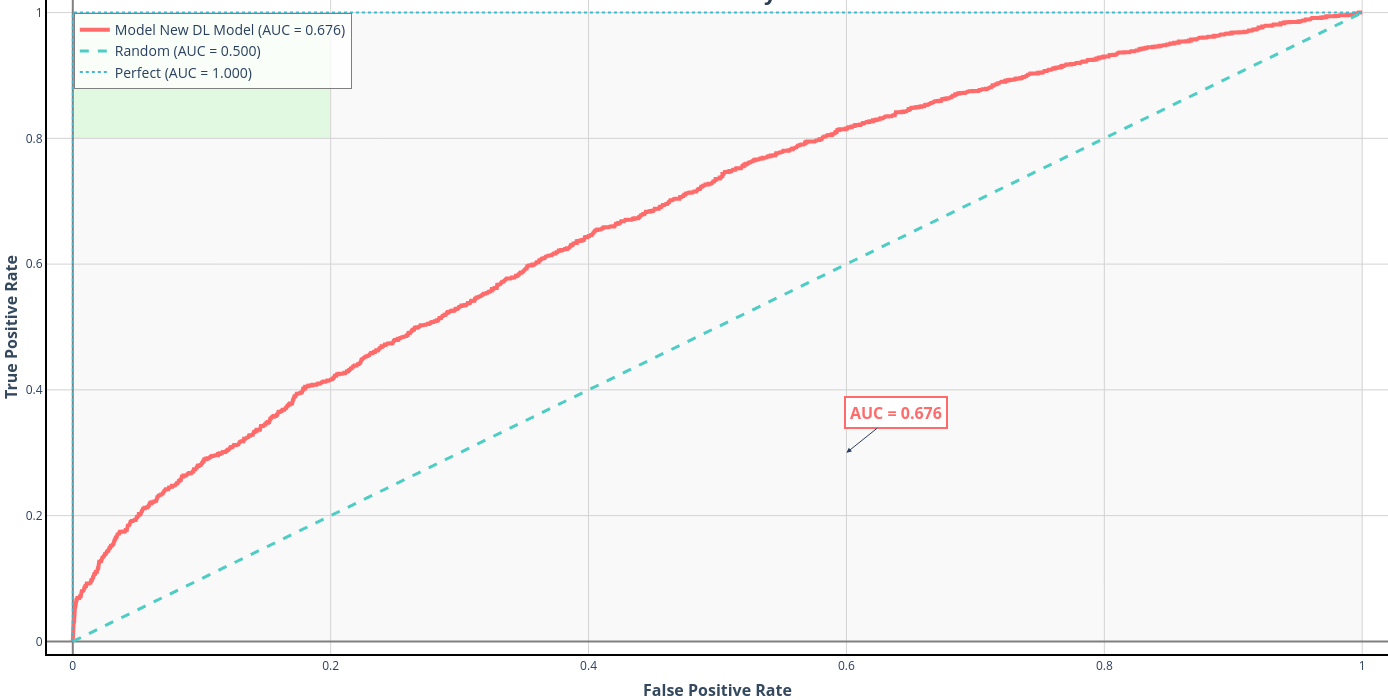

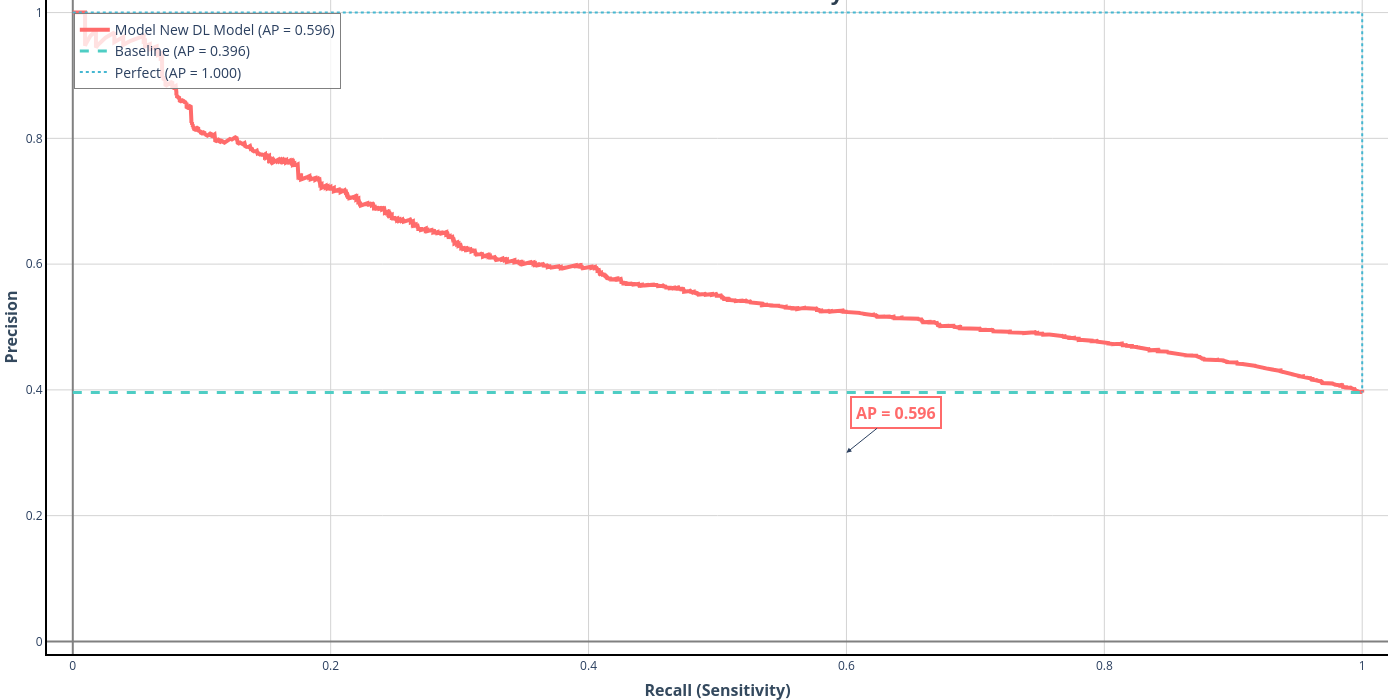

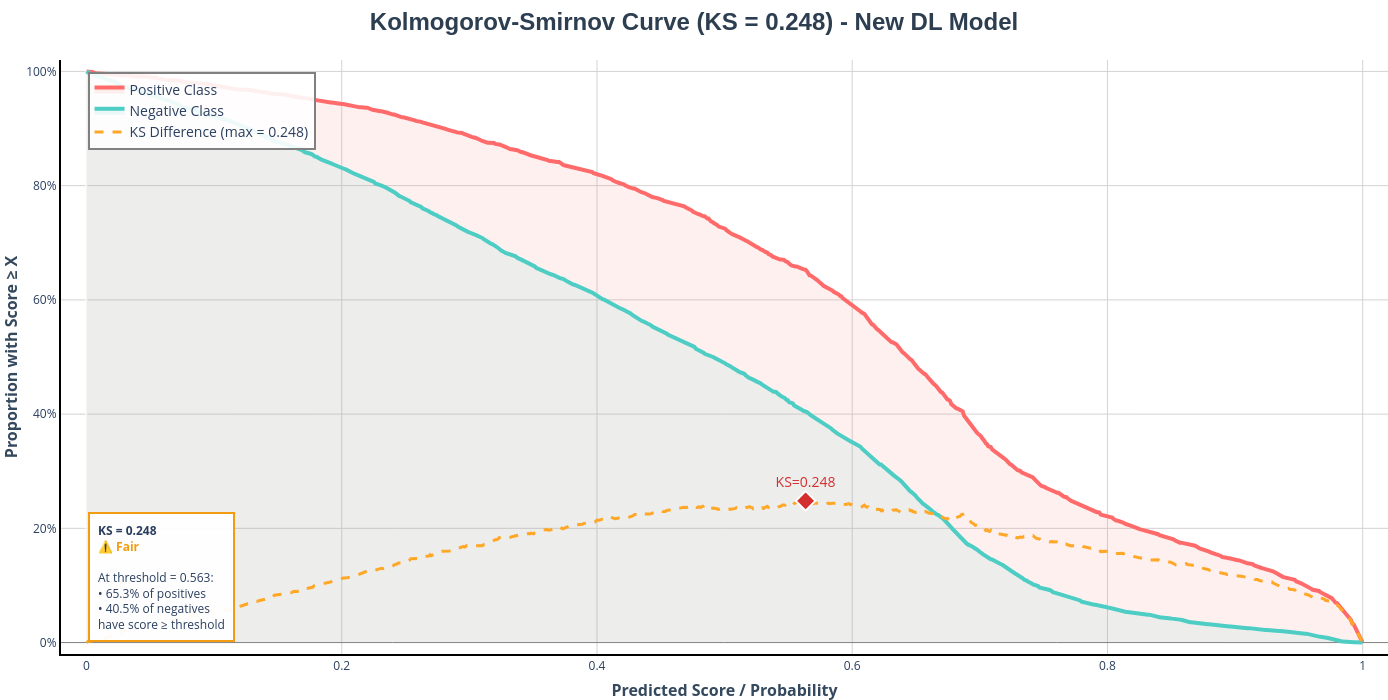

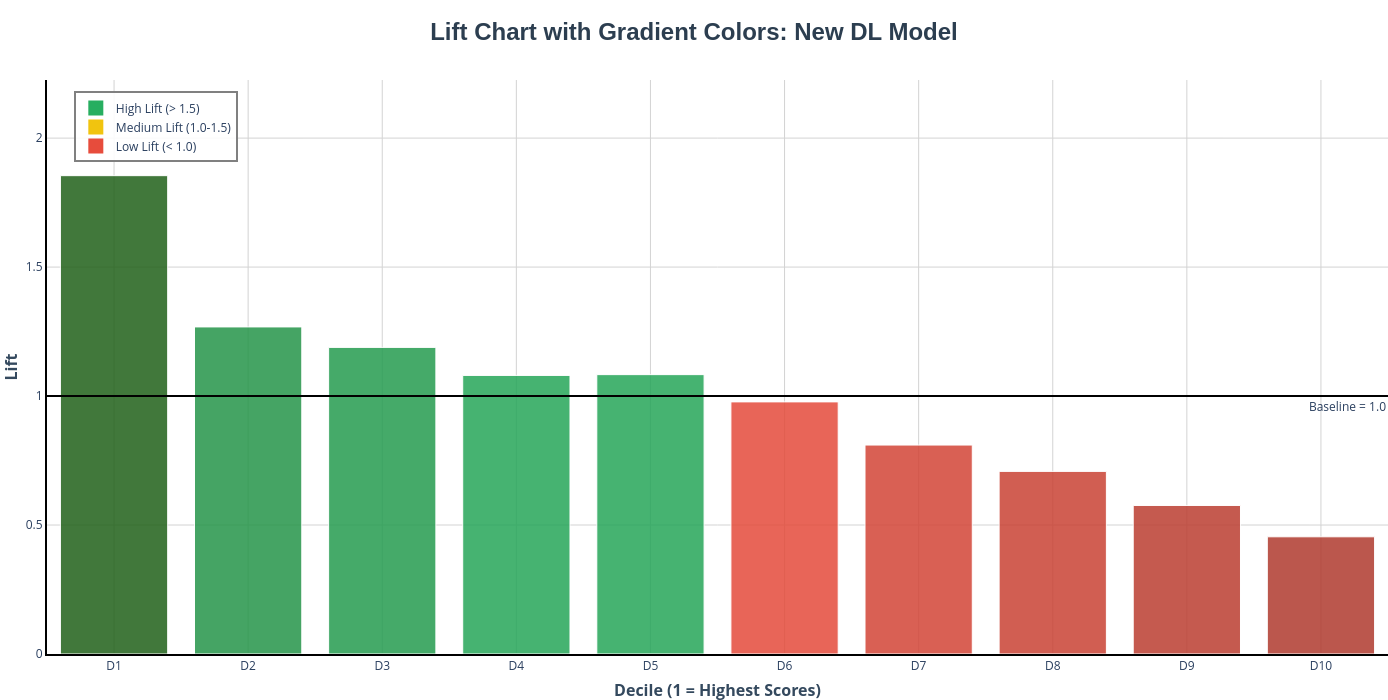

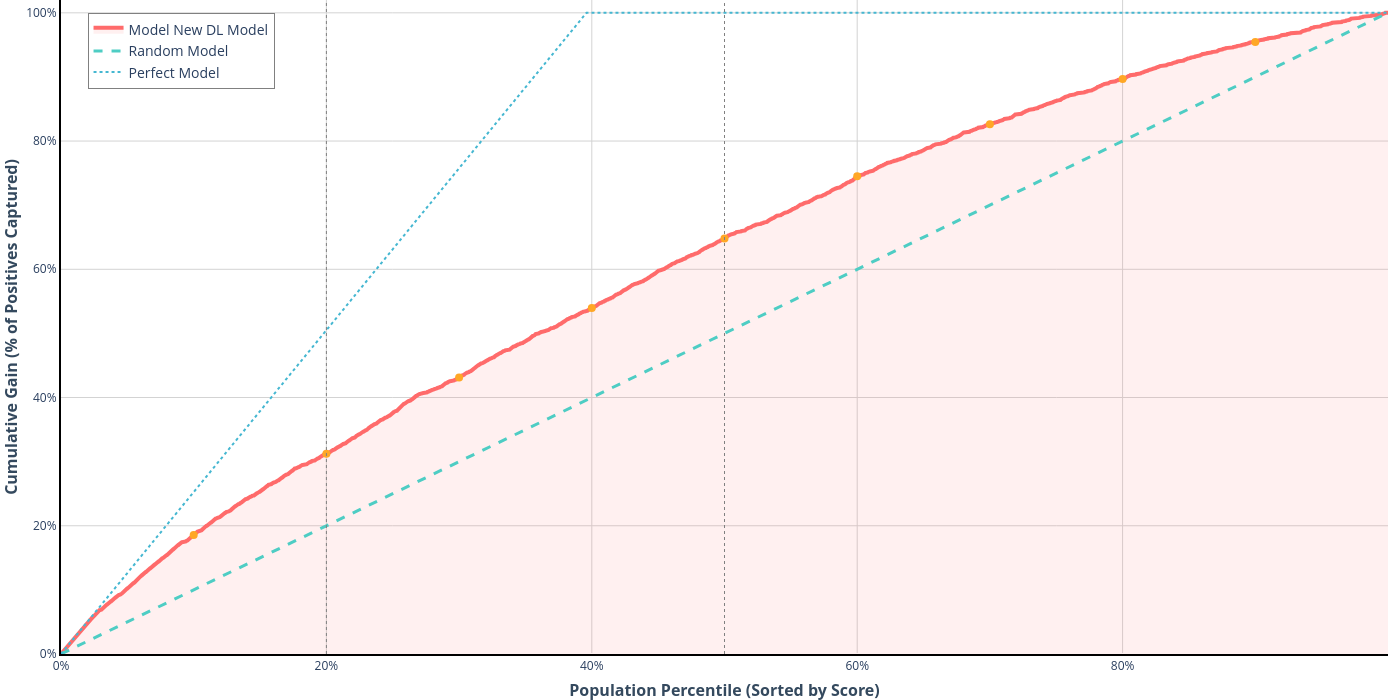

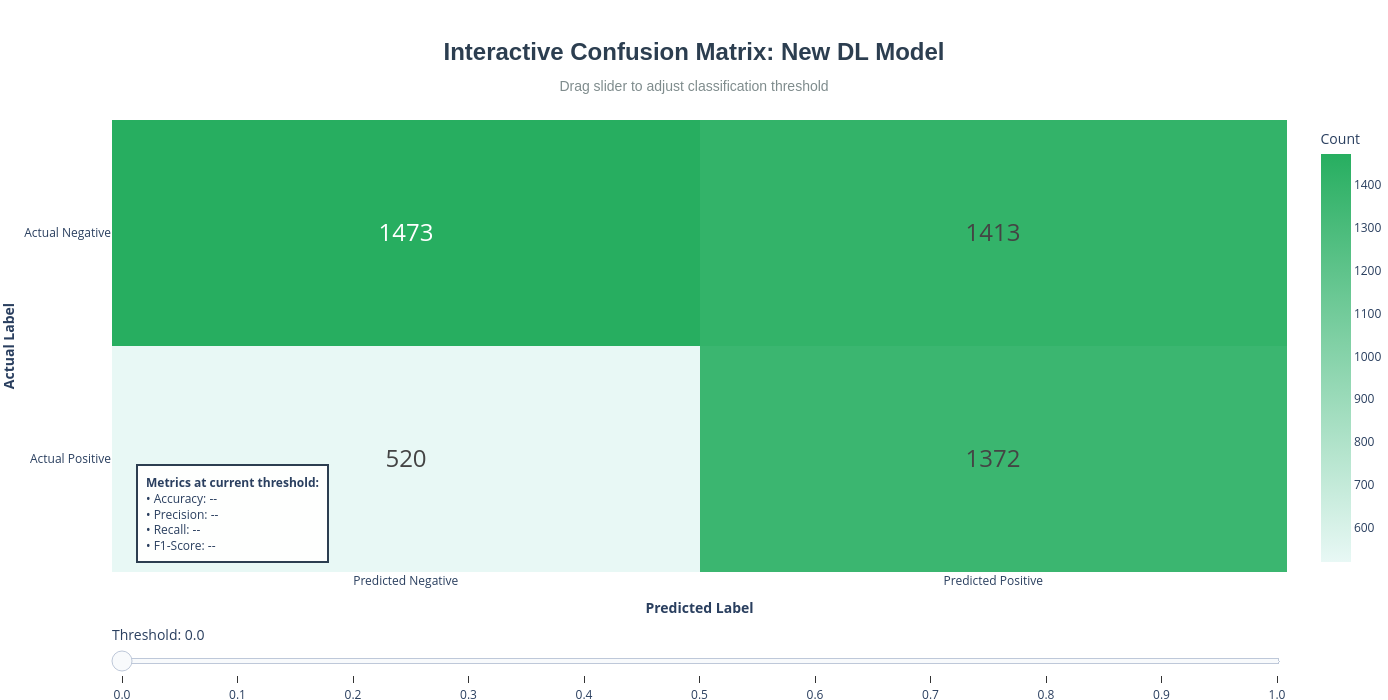

In [13]:
import torch
model = result['model']
X_test = result['X_test']
y_test = result['y_test']

X_test_numpy = X_test.values

# Get predictions directly
model.eval()
with torch.no_grad():
    X_tensor = torch.FloatTensor(X_test_numpy)
    predictions = model(X_tensor)
    
    # Convert to probabilities
    if predictions.shape[1] == 1:
        y_pred_proba = torch.sigmoid(predictions).numpy().flatten()
    else:
        y_pred_proba = torch.softmax(predictions, dim=1)[:, 1].numpy()

plots = log_all_plots(y_test, y_pred_proba, wandb_run_id, "New DL Model")

plots = log_all_plots(y_test, y_pred_proba, wandb_run_id, "New DL Model")
for k, plot in plots.items():
    plot.show()